In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
from rich import print
from typing import Tuple
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def preprocess_data_multiclass(df: pd.DataFrame, column: str = 'category') -> Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]:
    """
    Preprocesses the input DataFrame for a multiclass classification task.
    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str, optional): The target column. Defaults to 'category'.
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]: Training features, validation features, training labels, validation labels, and the LabelEncoder.
    """
    df = df.copy()

    # Encode categorical target
    le = LabelEncoder()
    y = le.fit_transform(df[column])

    # Drop unnecessary columns
    X = df.drop(['is_benign', 'attack', 'category'], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=37)

    return X_train, X_val, y_train, y_val, le

In [3]:
def evaluate_model(y_true, y_pred, model_name="Model", class_names=None):
    """
    Print comprehensive model evaluation metrics with both rich text output and seaborn heatmap.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    model_name : str, optional
        Name of the model for display purposes
    class_names : list, optional
        List of class names for axis labels
    """
    
    # Calculate core metrics
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1 Score": f1_score(y_true, y_pred, average='weighted')
    }
    
    # Create metrics table
    table_data = [[metric, f"{value:.5f}"] for metric, value in metrics.items()]
    table = tabulate(table_data, headers=["Metric", "Score"], tablefmt="psql")
    
    print(table)
    
    # Calculate and plot confusion matrix as heatmap
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    plt.figure(figsize=(20, 10))
    if class_names is None:
        class_names = [f"Class {i}" for i in range(cm.shape[0])]
    
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'{model_name} - Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')    
    plt.tight_layout()
    plt.show()
    
    return metrics

In [4]:
# Adjusting our scorer to fit a multiclass classification

from sklearn.metrics import make_scorer

# Define average_score to take y_true and y_pred
def average_score(y_true, y_pred):
    return (accuracy_score(y_true, y_pred) + 
            precision_score(y_true, y_pred, average='macro') + 
            recall_score(y_true, y_pred, average='macro') + 
            f1_score(y_true, y_pred, average='macro')) / 4


In [5]:
def train_xgboost(df):

    X_train, X_test, y_train, y_test, le = preprocess_data_multiclass(df)
    
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(le.classes_)),
        random_state=37,
        n_estimators=100,
        learning_rate=0.1
    )
    
    param_space = {
        'max_depth': (5, 50),
        'min_child_weight': (1, 6),
        'gamma': (0, 0.5),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    }

    average_scorer = make_scorer(average_score)
    
    bayes_search = BayesSearchCV(
        estimator = model,
        search_spaces = param_space,
        n_iter=37,
        cv=3,
        scoring=average_scorer,
        n_jobs=-1,
        verbose=0,
        random_state=37
    )
    
    bayes_search.fit(X_train, y_train)
    best_model = bayes_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    evaluate_model(y_test, y_pred, "XGBoost Multiclass", le.classes_)
    
    return best_model

+-----------+---------+
| Metric    |   Score |
|-----------+---------|
| Accuracy  | 0.99558 |
| Precision | 0.99555 |
| Recall    | 0.99558 |
| F1 Score  | 0.99553 |
+-----------+---------+

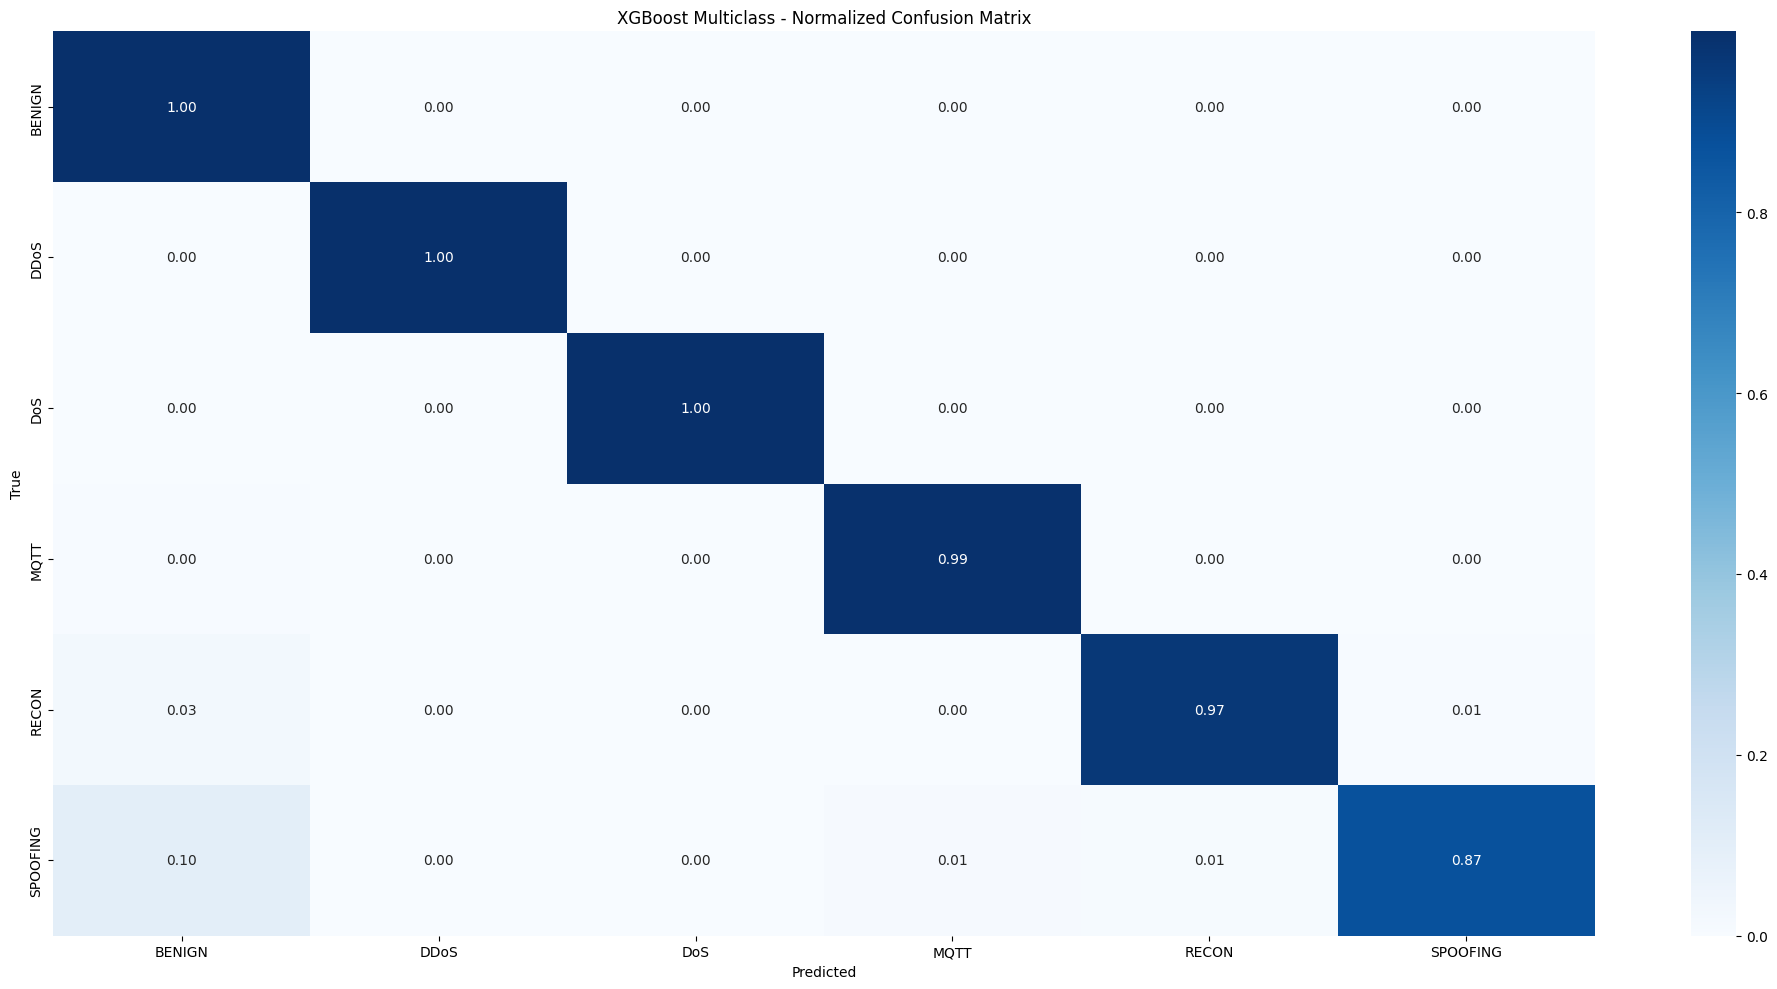

In [6]:
# Usage
df = pd.read_csv('/kaggle/input/dataset/train_sel_hclust.csv')

best_model = train_xgboost(df)
best_model.save_model('xgboost_multiclass.json')